In [1]:
from brpylib import NsxFile
import os
import numpy as np
import matplotlib.pyplot as plt

import direct_neural_biasing as dnb

## read data

In [2]:
data_file = np.load('data/Patient2EEG.npy')
mrk_file = 'data/Patient02_OfflineMrk.mrk'
data = data_file[0]

In [3]:
np.shape(data)

(83220000,)

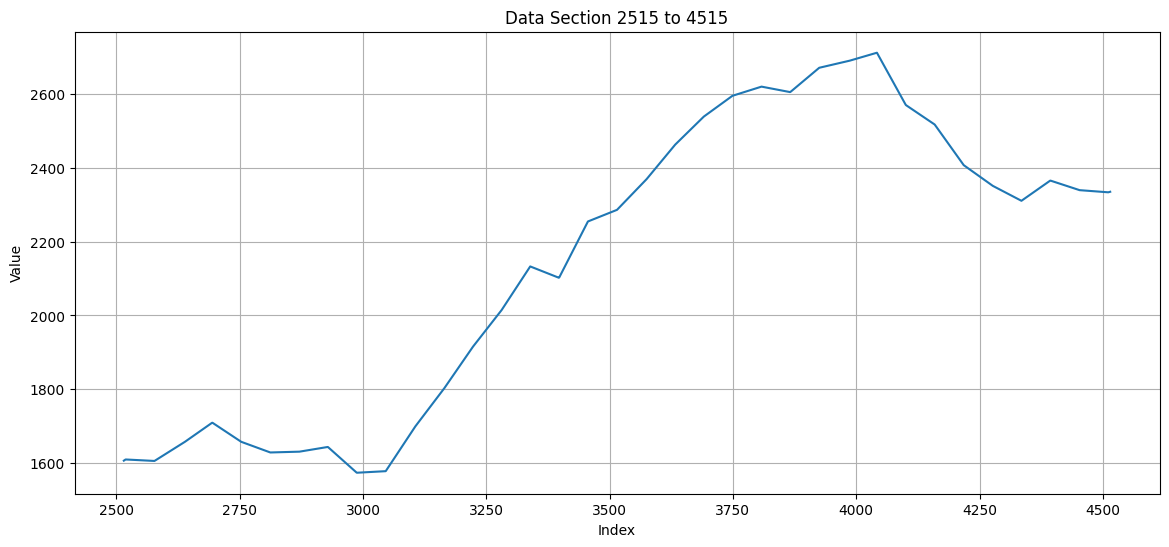

In [4]:
def plot_data_stream_section(data_stream, n, m):
    """
    Plots an n-m section of a 1D integer data stream as a line graph.

    Args:
        data_stream (list or numpy.ndarray): The 1D integer data stream.
        n (int): The starting index (inclusive).
        m (int): The ending index (inclusive).
    """
    section = data_stream[n : m + 1]
    indices = range(n, m + 1)

    plt.figure(figsize=(14, 6))
    plt.plot(indices, section)
    plt.title(f'Data Section {n} to {m}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

start_t = 2515
end_t = 4515

plot_data_stream_section(data, start_t, end_t)

In [5]:
# --- Concise .mrk file parser ---
def parse_mrk_file_concise(filepath):
    """
    Parses a .mrk file into a dictionary (signal_type: [indices]).
    Assumes first line is header, subsequent lines are 'index index signal_type'.
    """
    mrk_data = {}
    with open(filepath, 'r') as f:
        next(f) # Skip header line
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                index = int(parts[0])
                signal_type = parts[2]
                mrk_data.setdefault(signal_type, []).append(index)
    return mrk_data

def plot_marker_with_context(data_stream, marker_index, signal_type, context_window=500, output_dir="marker_plots"):
    """
    Plots a single marker with surrounding data context.
    """
    marker_index = int((marker_index / 512) * 30000) # adjust for differe3nces in sample rate
    data_length = len(data_stream)
    plot_start = max(0, marker_index - context_window)
    plot_end = min(data_length - 1, marker_index + context_window)

    section_data = data_stream[plot_start : plot_end + 1]
    section_indices = range(plot_start, plot_end + 1)

    # CORRECTED LINE: Check if the section_data is empty using its length/size
    if len(section_data) == 0: # or if section_data.size == 0: if you're sure it's a numpy array
        print(f"Skipping plot for marker {marker_index} ({signal_type}) due to empty data section.")
        return

    plt.figure(figsize=(14, 6))
    plt.plot(section_indices, section_data, label='Continuous Data', color='blue', linewidth=1.5)

    # Highlight the marker point
    plt.axvline(x=marker_index, color='red', linestyle='--', label=f'Marker: {signal_type}')
    # Ensure the marker_index is within the bounds of data_stream before trying to access it
    if 0 <= marker_index < data_length:
        plt.plot(marker_index, data_stream[marker_index], 'ro', markersize=8, label='Marker Location')
    else:
        print(f"Warning: Marker index {marker_index} is out of bounds for data_stream. Cannot plot marker point.")


    plt.title(f'Signal Type: {signal_type} at Index: {marker_index} (Context: $\pm${context_window})')
    plt.xlabel('Data Index')
    plt.ylabel('Value')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    plt.close()


Parsed Markers:
  offlineSW: [3515, 7210, 7897, 14431, 16326]... (208 total)

Generating and displaying the first 10 plots with context window of $\pm$100000...


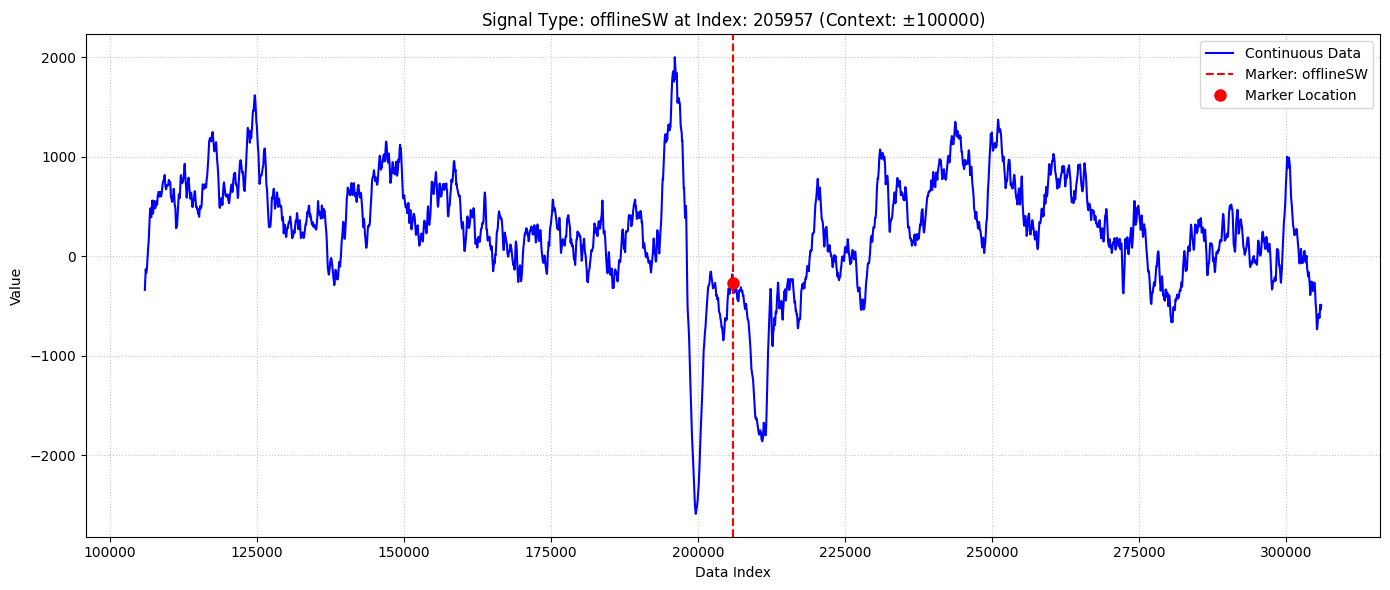

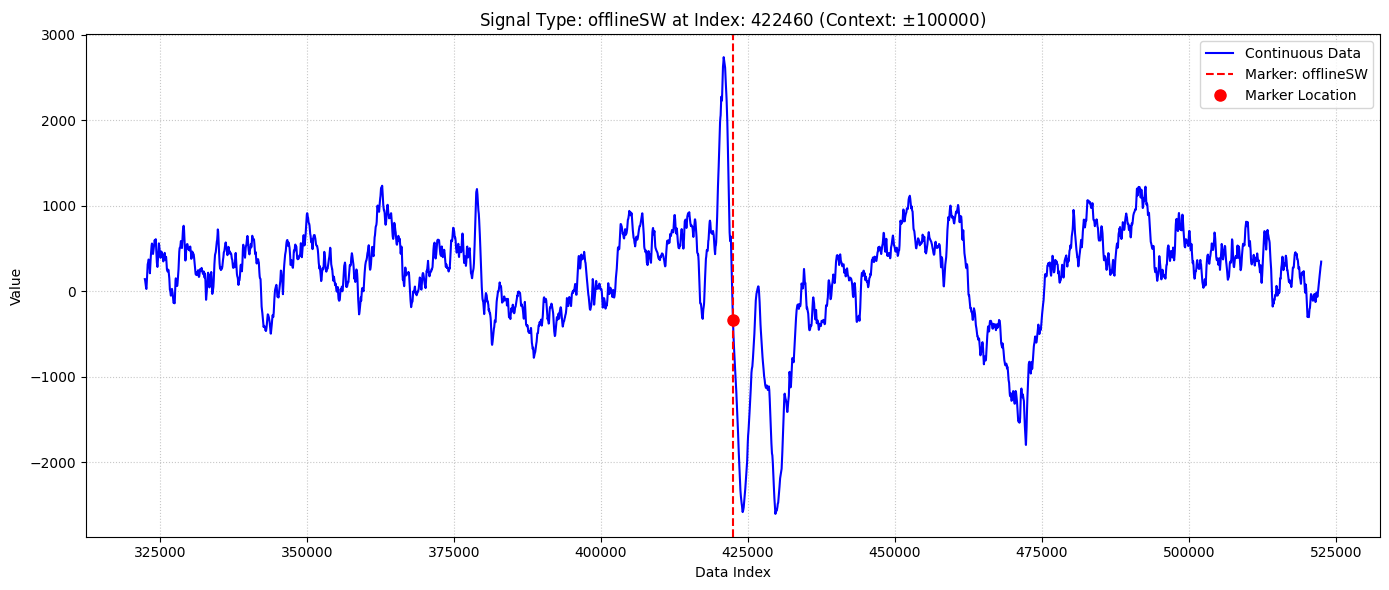

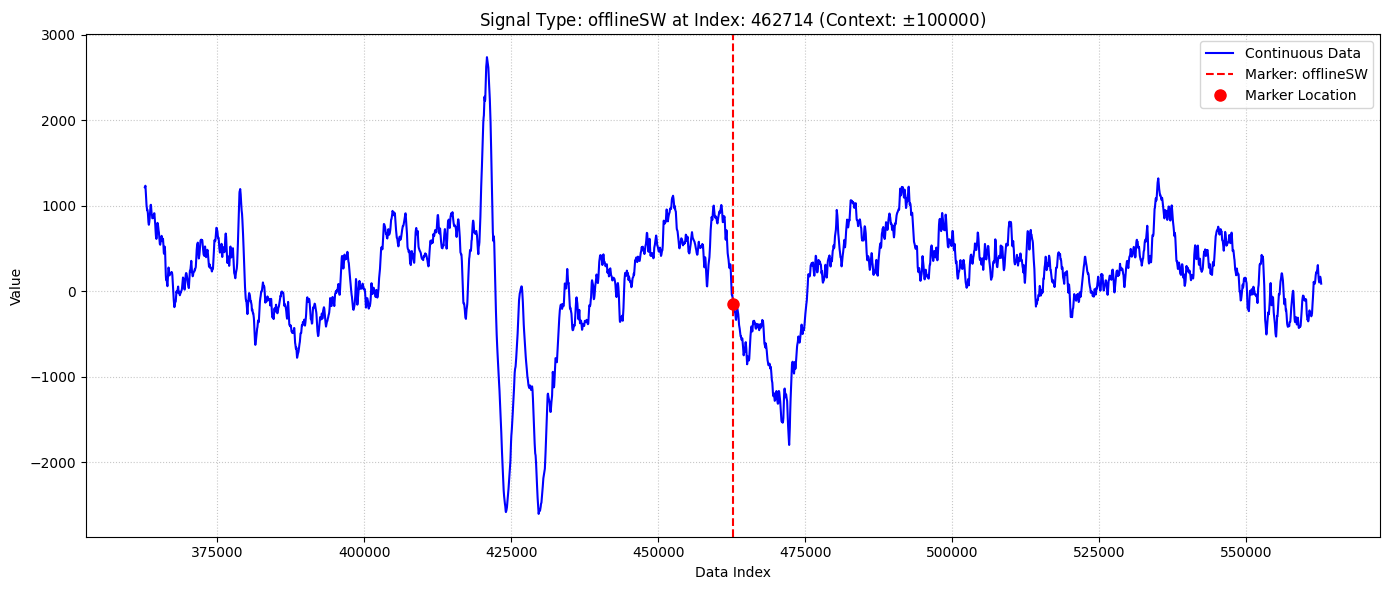

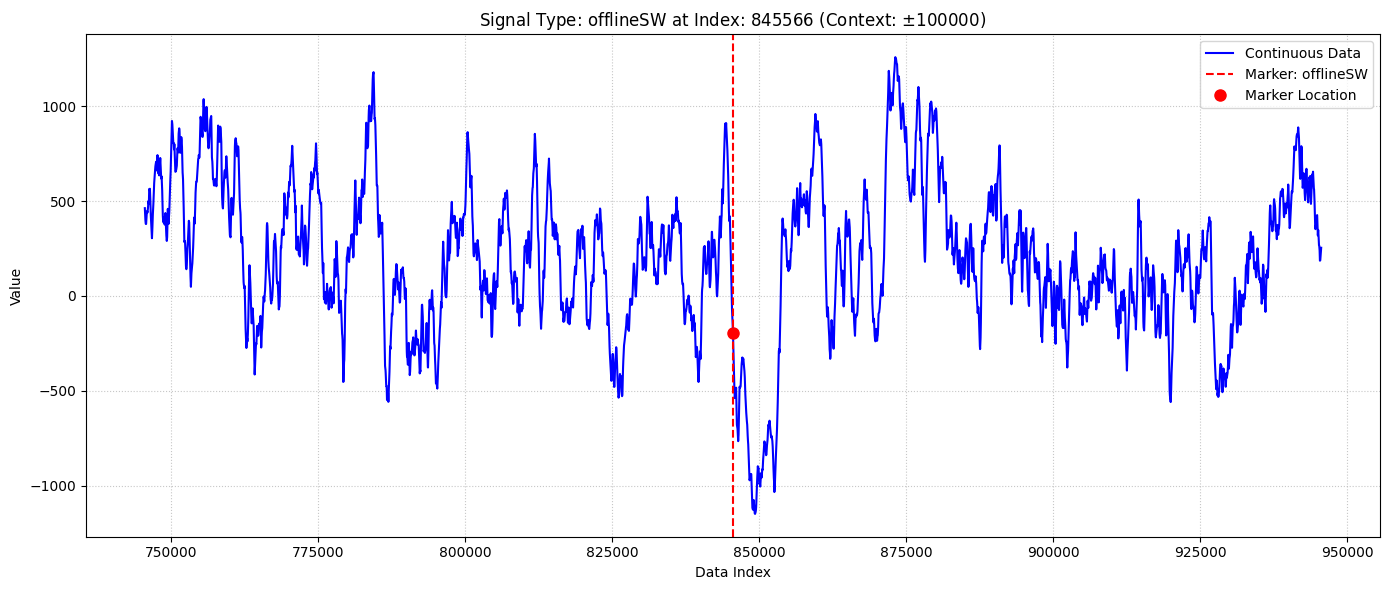

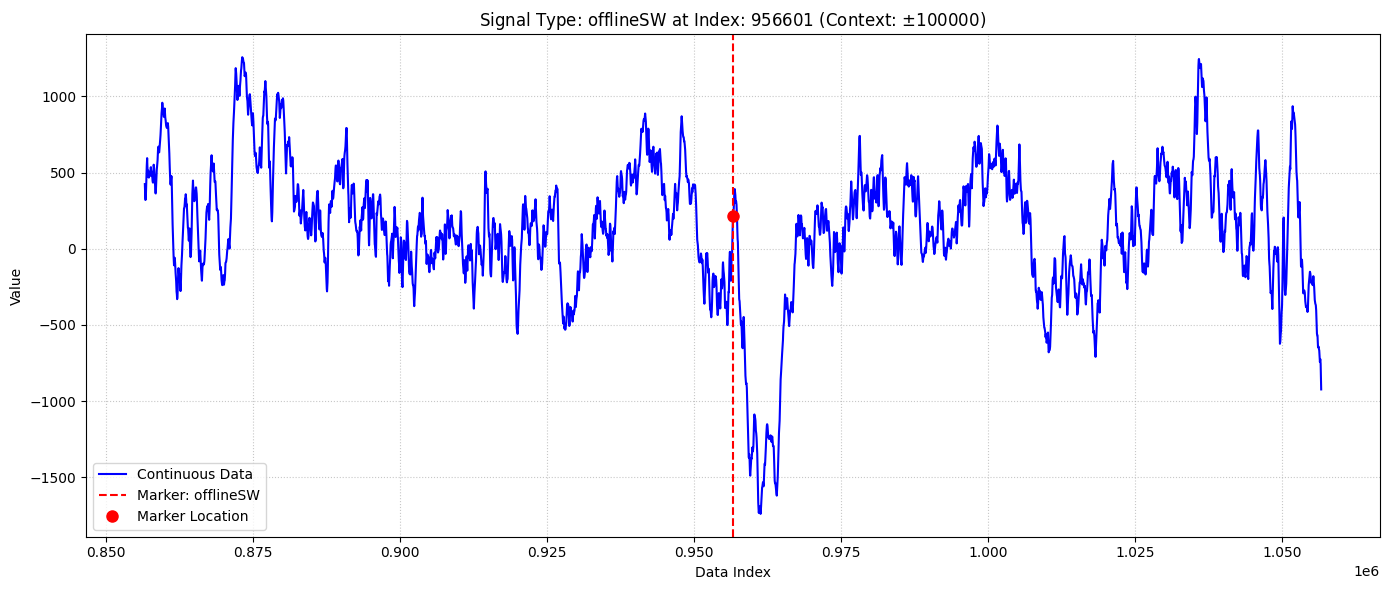

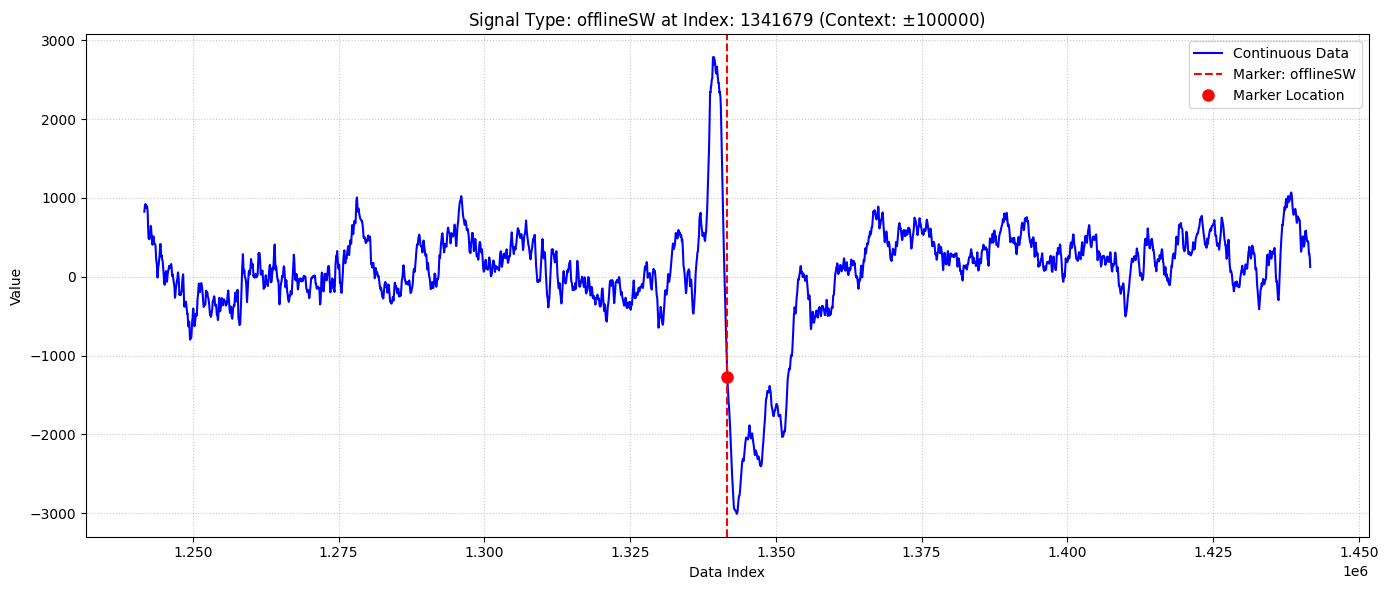

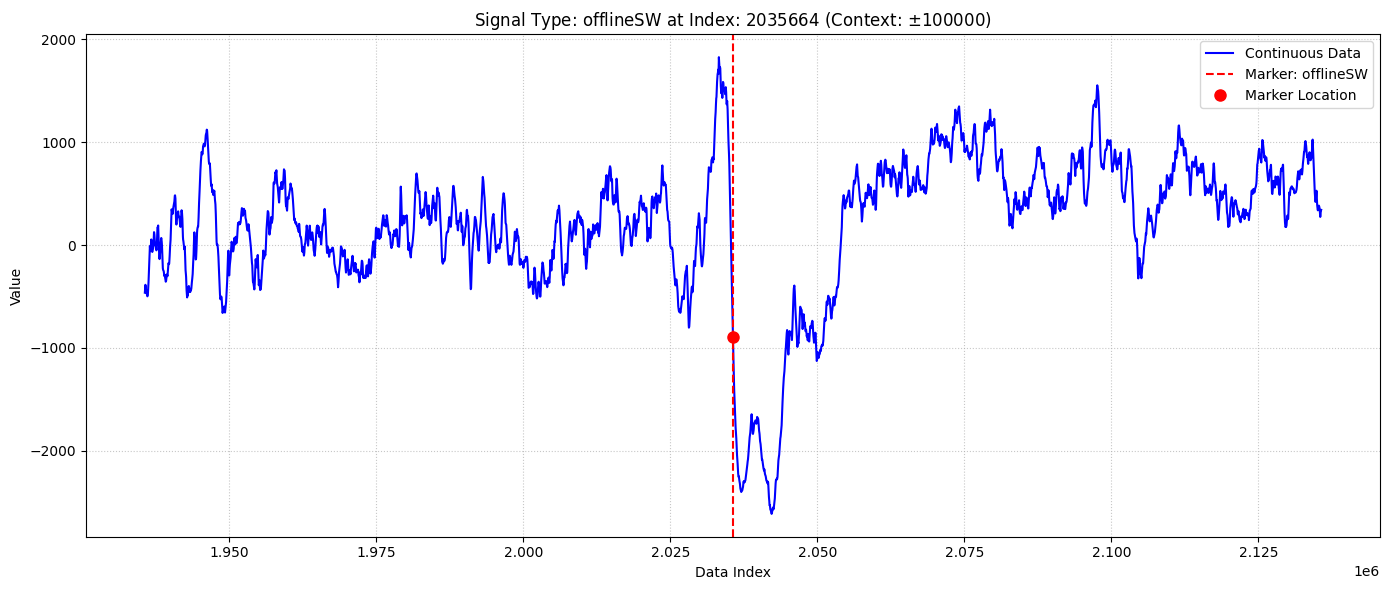

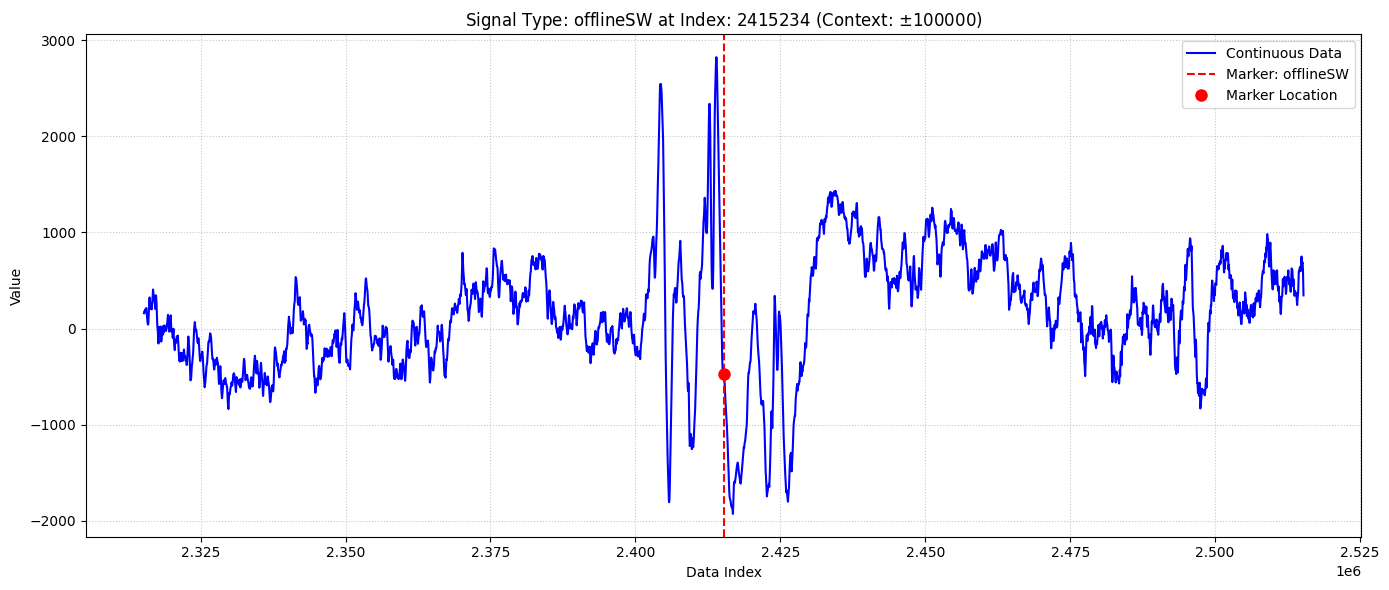

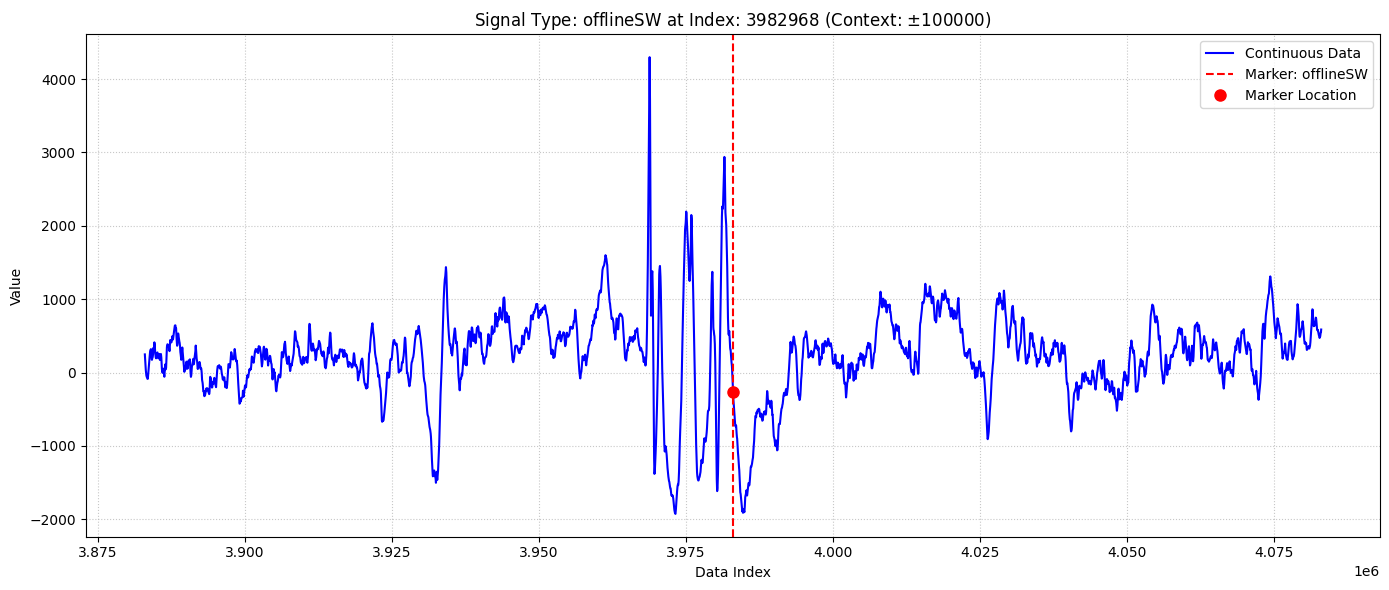

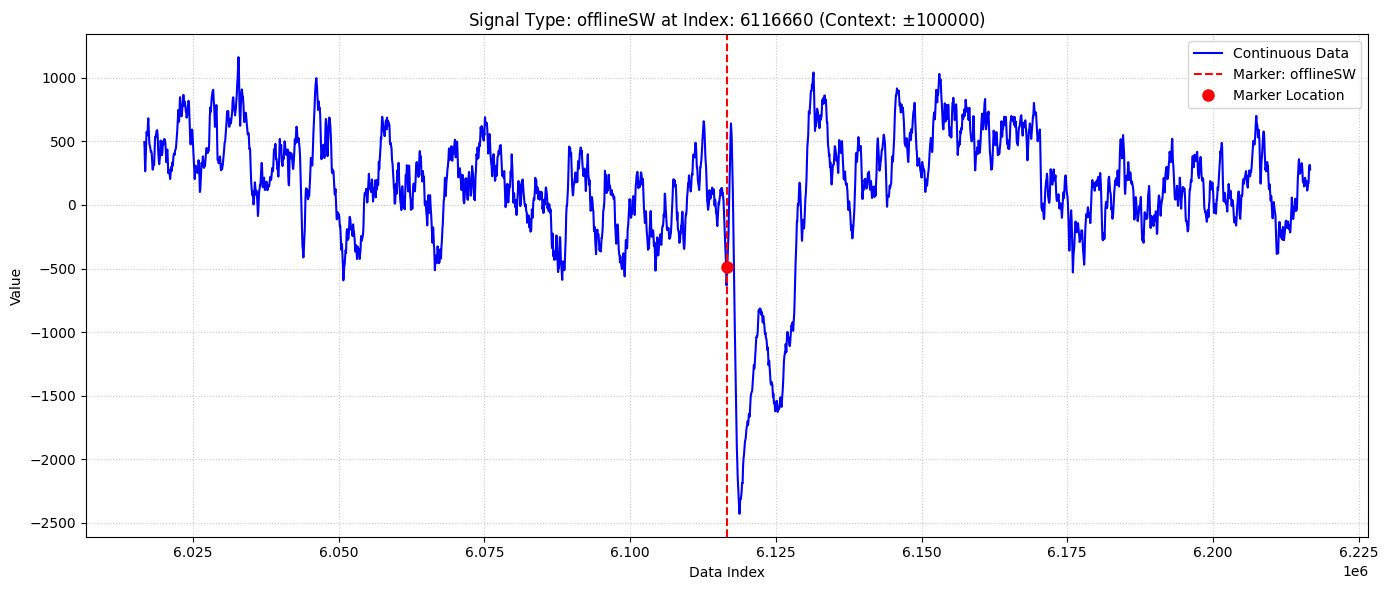


Finished displaying the first 10 marker plots.


In [6]:
# --- Main Execution ---

# 1. Parse the .mrk file
parsed_markers = parse_mrk_file_concise(mrk_file)
print("\nParsed Markers:")
for signal_type, indices in parsed_markers.items():
    print(f"  {signal_type}: {indices[:5]}... ({len(indices)} total)")

# 2. Plot each marker with context (first 10, show only)
context_window_size = 100000 # Adjust this to change how much data is shown around each marker
max_plots_to_show = 10
plots_shown_count = 0

print(f"\nGenerating and displaying the first {max_plots_to_show} plots with context window of $\pm${context_window_size}...")

# Iterate through signal types and their indices
for signal_type, indices in parsed_markers.items():
    for marker_index in indices:
        if plots_shown_count < max_plots_to_show:
            plot_marker_with_context(data, marker_index, signal_type, context_window=context_window_size)
            plots_shown_count += 1
        else:
            # Once 10 plots are shown, break out of the inner loop
            break
    if plots_shown_count >= max_plots_to_show:
        # If 10 plots are shown, break out of the outer loop too
        break

if plots_shown_count == 0:
    print("No plots were generated. Check your .mrk file or data stream.")
else:
    print(f"\nFinished displaying the first {plots_shown_count} marker plots.")

In [8]:
#!/usr/bin/env python3
"""
DirectNeuralBiasing Python Script using YAML Configuration
"""

import direct_neural_biasing as dnb
import numpy as np
import yaml
import os
from pathlib import Path
import time
from collections import deque

def create_config_file(config_path="config.yaml"):
    """Create a sample configuration file"""
    config = {
        'processor': {
            'verbose': True,
            'fs': 512.0,
            'channel': 1,
            'enable_debug_logging': True
        },
        'filters': {
            'bandpass_filters': [
                {
                    'id': 'slow_wave_filter',
                    'f_low': 0.5,
                    'f_high': 4.0
                },
                {
                    'id': 'ied_filter', 
                    'f_low': 80.0,
                    'f_high': 120.0
                }
            ]
        },
        'detectors': {
            'wave_peak_detectors': [
                {
                    'id': 'slow_wave_detector',
                    'filter_id': 'slow_wave_filter',
                    'z_score_threshold': 2.0,
                    'sinusoidness_threshold': 0.7,
                    'check_sinusoidness': False,
                    'wave_polarity': 'downwave',
                    'min_wave_length_ms': 500.0,
                    'max_wave_length_ms': 2000.0
                },
                {
                    'id': 'ied_detector',
                    'filter_id': 'ied_filter',
                    'z_score_threshold': 1.5,
                    'sinusoidness_threshold': 0.0,
                    'check_sinusoidness': False,
                    'wave_polarity': 'upwave',
                    'min_wave_length_ms': None,
                    'max_wave_length_ms': None
                }
            ]
        },
        'triggers': {
            'pulse_triggers': [
                {
                    'id': 'pulse_trigger',
                    'activation_detector_id': 'slow_wave_detector',
                    'inhibition_detector_id': 'ied_detector',
                    'inhibition_cooldown_ms': 2000.0,
                    'pulse_cooldown_ms': 2000.0
                }
            ]
        }
    }
    
    with open(config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, indent=2)
    
    print(f"Created configuration file: {config_path}")
    return config_path

# def load_test_data(file_path):
#     """Load test data from file (assuming CSV format)"""
#     if file_path.endswith('.csv'):
#         data = np.loadtxt(file_path, delimiter=',')
#     elif file_path.endswith('.npy'):
#         data = np.load(file_path)
#     else:
#         # Assume text file with one value per line
#         data = np.loadtxt(file_path)
    
#     print(f"Loaded {len(data)} samples from {file_path}")
#     return data

def process_data_in_chunks(signal_processor, data, chunk_size=4096, context_size=2000):
    """Process data in chunks while maintaining context around events"""
    buffer_size = (context_size * 2) + 1
    event_buffer = deque(maxlen=buffer_size)
    detected_events = []
    chunk_count = 0
    total_chunks = (len(data) + chunk_size - 1) // chunk_size
    
    # Reset index before processing
    signal_processor.reset_index()
    
    print(f"Processing {len(data)} samples in {total_chunks} chunks of size {chunk_size}")
    
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i + chunk_size].tolist()  # Convert to list for Rust
        chunk_count += 1
        
        start_time = time.time()
        chunk_output, trigger_timestamp = signal_processor.run_chunk(chunk)
        processing_time = time.time() - start_time
        
        print(f"Processed chunk {chunk_count}/{total_chunks} in {processing_time:.4f}s")
        
        if trigger_timestamp:
            print(f"  🔥 TRIGGER at timestamp: {trigger_timestamp}")
        
        # Store samples in event buffer
        for sample_result in chunk_output:
            event_buffer.append(sample_result)
            
            # Check if buffer is full and middle sample is an event
            if len(event_buffer) >= buffer_size:
                middle_sample = event_buffer[context_size]
                
                # Check for trigger event
                if middle_sample.get("triggers:pulse_trigger:triggered", 0.0) == 1.0:
                    print(f"  📊 Event detected with context!")
                    # Save the context around the event
                    detected_events.append({
                        'context': list(event_buffer),
                        'trigger_timestamp': trigger_timestamp,
                        'chunk': chunk_count,
                        'global_index': middle_sample.get("global:index", -1)
                    })
                
                # Remove oldest sample
                event_buffer.popleft()
    
    return detected_events

def analyze_results(events):
    """Analyze the detected events"""
    print(f"\n📈 ANALYSIS RESULTS:")
    print(f"Total events detected: {len(events)}")
    
    if not events:
        print("No events detected.")
        return
    
    # Analyze event timing
    timestamps = [e['trigger_timestamp'] for e in events if e['trigger_timestamp']]
    if len(timestamps) > 1:
        intervals = np.diff(timestamps)
        print(f"Mean interval between events: {np.mean(intervals):.3f}s")
        print(f"Std interval between events: {np.std(intervals):.3f}s")
    
    # Analyze event characteristics
    for i, event in enumerate(events):
        middle_idx = len(event['context']) // 2
        middle_sample = event['context'][middle_idx]
        
        print(f"\nEvent {i+1}:")
        print(f"  Global Index: {middle_sample.get('global:index', 'N/A')}")
        print(f"  Raw Sample: {middle_sample.get('global:raw_sample', 'N/A'):.3f}")
        print(f"  Slow Wave Z-Score: {middle_sample.get('detectors:slow_wave_detector:statistics:z_score', 'N/A'):.3f}")
        print(f"  Peak Amplitude: {middle_sample.get('detectors:slow_wave_detector:peak_z_score_amplitude', 'N/A'):.3f}")
        print(f"  Predicted Next Maxima: {middle_sample.get('detectors:slow_wave_detector:predicted_next_maxima_index', 'N/A')}")

def main():
    """Main execution function"""
    print("🧠 DirectNeuralBiasing Python Demo")
    print("=" * 50)
    
    # 1. Create or check for config file
    config_path = "config.yaml"
    if not os.path.exists(config_path):
        print(f"Config file not found. Creating {config_path}...")
        create_config_file(config_path)
    else:
        print(f"Using existing config file: {config_path}")
    
    # 2. Load data (modify this path to your data file)
    # data_file = "test_waveform.csv"  # Change this to your data file path
    
    # if not os.path.exists(data_file):
    #     print(f"❌ Data file not found: {data_file}")
    #     print("Please specify the correct path to your test data file.")
    #     return
    
    # try:
    #     data = load_test_data(data_file)
    # except Exception as e:
    #     print(f"❌ Error loading data: {e}")
    #     return
    
    # 3. Initialize signal processor from config
    try:
        print(f"\n🔧 Initializing signal processor from {config_path}...")
        signal_processor = dnb.PySignalProcessor.from_config_file(config_path)
        print("✅ Signal processor initialized successfully!")
    except Exception as e:
        print(f"❌ Error initializing signal processor: {e}")
        return
    
    # 4. Process the data
    try:
        print(f"\n⚡ Processing data...")
        events = process_data_in_chunks(signal_processor, data, chunk_size=4096, context_size=2000)
        print("✅ Data processing completed!")
    except Exception as e:
        print(f"❌ Error during processing: {e}")
        return
    
    # 5. Analyze results
    analyze_results(events)
    
    # 6. Check log files
    log_dir = "logs"
    if os.path.exists(log_dir):
        log_files = [f for f in os.listdir(log_dir) if f.endswith('.log')]
        print(f"\n📝 Log files created:")
        for log_file in log_files:
            log_path = os.path.join(log_dir, log_file)
            size = os.path.getsize(log_path)
            print(f"  {log_file}: {size} bytes")
    
    print(f"\n🎉 Demo completed successfully!")

if __name__ == "__main__":
    main()

🧠 DirectNeuralBiasing Python Demo
Using existing config file: config.yaml

🔧 Initializing signal processor from config.yaml...
❌ Error initializing signal processor: type object 'builtins.PySignalProcessor' has no attribute 'from_config_file'


In [7]:
# List all available methods
print("Available methods:")
for attr in dir(dnb.PySignalProcessor):
    if not attr.startswith('_'):
        print(f"  - {attr}")

Available methods:
  - add_filter
  - add_pulse_trigger
  - add_slow_wave_detector
  - add_threshold_detector
  - add_wave_peak_detector
  - reset_index
  - run_chunk
